# Lab N
### Morphology

Skimage morphology operators' documentation:
https://scikit-image.org/docs/dev/api/skimage.morphology.html

In [1]:
from commonfunctions import *
import numpy as np
import skimage.io as io
import matplotlib.pyplot as plt
from skimage.color import rgb2gray
from skimage.morphology import binary_erosion, binary_dilation, binary_closing,skeletonize, thin
from skimage.measure import find_contours
from skimage.draw import rectangle


# Show the figures / plots inside the notebook
%matplotlib inline
%load_ext autoreload
%autoreload 2

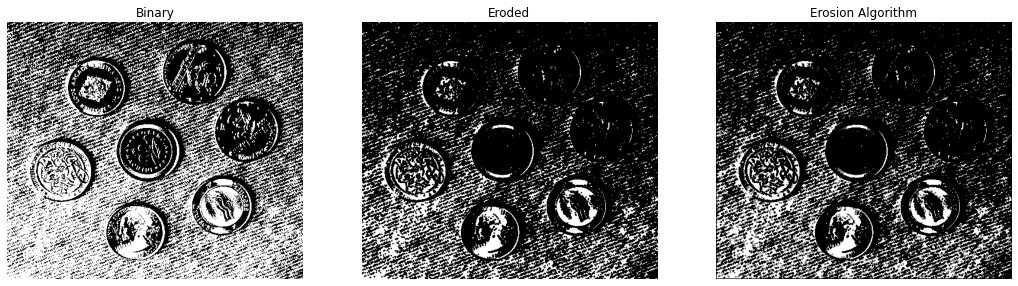

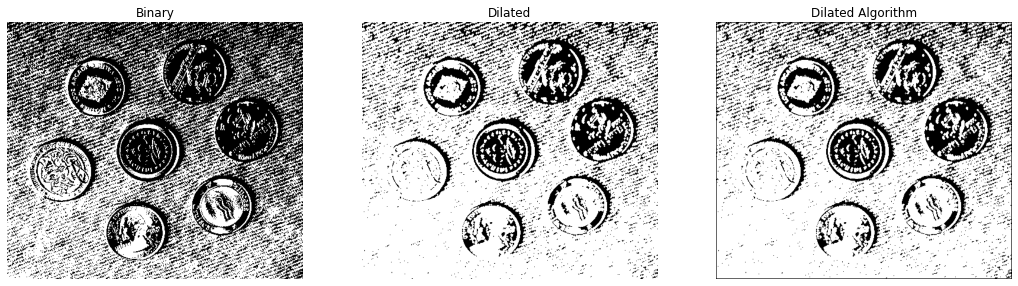

In [2]:
'''
1) Erosion / Dilation:
    - Load "coins.jpg" from the img folder
    - Convert the image to binary
    - Write 2 functions each applying 1 of the erosion/dilation algorithms (with adjustable square window size) manually to the binary image
    - Use Skimage's "binary_erosion" & "binary_dilation" & show the results
'''

coins = rgb2gray(io.imread('./img/coins.jpg'))
binImg = coins > 0.58   
        
def erosion(img, struct):
    height_SE,width_SE=struct.shape
    height,width= img.shape
    imgErode= np.zeros((height,width))
    x = height_SE // 2
    y = width_SE // 2
    endx = (height_SE%2==0) and x or x+1
    endy = (width_SE%2==0) and y or y+1
    for i in range(x, height-x):
        for j in range(y, width-y):
            temp= img[i-x:i+endx, j-y:j+endy]
            product = temp&struct
            if(np.array_equal(product, struct)):
                imgErode[i][j]=1
    return imgErode
    
def dilation(img, struct):
    height_SE,width_SE=struct.shape
    height,width= img.shape
    imgDilated= np.zeros((height,width))
    x = height_SE // 2
    y = width_SE // 2
    endx = (height_SE%2==0) and x or x+1
    endy = (width_SE%2==0) and y or y+1
    for i in range(x, height-x):
        for j in range(y, width-y):
            temp= img[i-x:i+endx, j-y:j+endy]
            product = temp&struct
            if((product&struct==1).any()):
                imgDilated[i][j]=1
    return imgDilated
   
struct = np.array([[0, 1, 0],
                   [1, 0, 1],
                   [0, 1, 0]])
imgErode = erosion(binImg, struct)
ErodedImg = binary_erosion(binImg)
show_images([binImg,ErodedImg,imgErode],['Binary','Eroded','Erosion Algorithm'])    

imgDilated = dilation(binImg, struct)
DilatedImg = binary_dilation(binImg)
show_images([binImg,DilatedImg,imgDilated],['Binary','Dilated','Dilated Algorithm'])

In [3]:
def Dialation (binary_img,SE_width=3,SE_height=3):
    dialated_img = np.copy(binary_img)
    x = SE_width // 2
    y = SE_height // 2
    for i in range (y,binary_img.shape[0]-y):
        for j in range (x,binary_img.shape[1]-x):
            if (binary_img[i][j]):
                dialated_img[(i - y) : (i + y + 1), (j - x) : (j + x + 1)] = 1
    return dialated_img


def Erosion (binary_img,SE_width=3,SE_height=3):
    eroded_img = np.copy(binary_img)
    x = SE_width // 2   
    y = SE_height // 2
    for i in range (y,binary_img.shape[0]-y):
        for j in range (x,binary_img.shape[1]-x):
            eroded_img[i][j] = np.all(binary_img[(i - y):(i + y + 1),(j - x):(j + x + 1)])
    return eroded_img

In [4]:
def binary_thresholding(img,threshold):
    thresholding_image = np.copy(img)
    thresholding_image[thresholding_image>=threshold] = 1
    thresholding_image[thresholding_image<threshold] = 0
    return thresholding_image


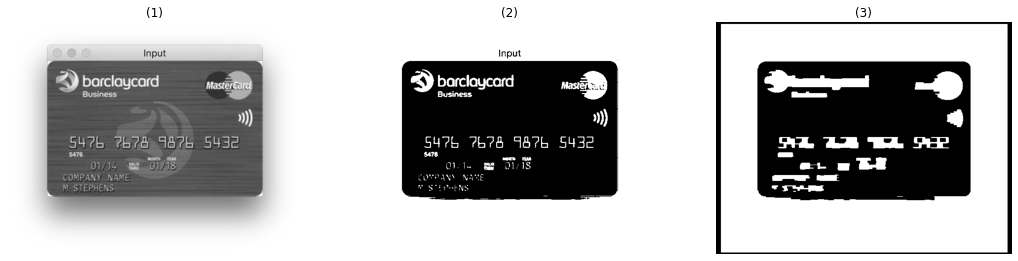

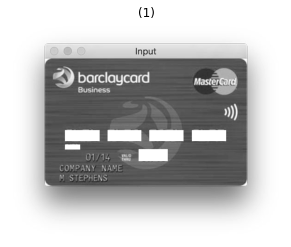

In [5]:
'''
2) Case Study: Credit Card Number Extraction
    - Load "card.jpg" from the img folder
    - Convert the image to binary by brightness thresholding maintaining the card number details for extraction
    - Use your erosion/dilation functions, or Skimage's functions only if you didn't implement them, to apply closing
        Note: The goal of this step is to join the card number into 4 sets of connected pixels
    - Use Skimage's "find_contours" to get the bounding boxes for the credit card's numbers by filtering on aspect ratio (between 2.5 & 3.5)
        Note: When using "find_contours(img, 0.8)" the o/p is a list of contours each having:
                - contour[:,0] being the Y values of the contour perimeter points
                - contour[:,1] being the X values of the contour perimeter points
'''

#When provided with the correct format of the list of bounding_boxes, this section will set all pixels inside boxes in img_with_boxes
card = io.imread('img/card.jpg',as_gray=1)
binarized_card = binary_thresholding(card,0.58)

binarized_card = binarized_card.astype(int)

struct1 = np.ones([4, 12], dtype = int)
struct2 = np.ones([4, 8], dtype = int)
closed_card = erosion(dilation(binarized_card,struct1).astype(int),struct2)

show_images([card,binarized_card,closed_card])
contours = find_contours(closed_card,0.8)
bounding_boxes = []
for contour in contours:
    x_cordinates =  contour[:, 1]
    x_max = x_cordinates.max()
    x_min = x_cordinates.min()
    width = x_max - x_min
    
    y_cordinates =  contour[:, 0]
    y_max = y_cordinates.max()
    y_min = y_cordinates.min()
    height = y_max - y_min
    ratio = width / height
    if ratio >= 2.5 and ratio <= 3.5:
        box = (x_min,x_max,y_min,y_max)
        bounding_boxes.append(box)

# When provided with the correct format of the list of bounding_boxes, this section will set all pixels inside boxes in img_with_boxes
img_with_boxes = np.copy(card)

for box in bounding_boxes:
    [Xmin, Xmax, Ymin, Ymax] = box
    rr, cc = rectangle(start = (Ymin,Xmin), end = (Ymax,Xmax), shape=card.shape)
    rr_rounding = np.round(rr).astype(int)
    cc_rounding = np.round(cc).astype(int)
    img_with_boxes[rr_rounding, cc_rounding] = 1 #set color white
    
show_images([img_with_boxes])

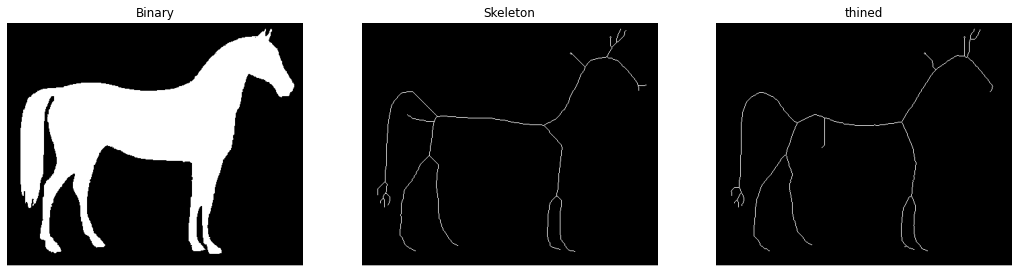

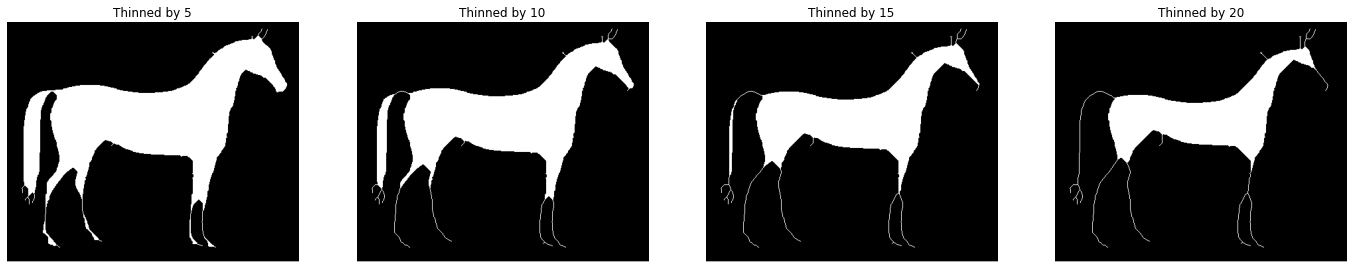

In [7]:
'''
3) Skeletonization:
    - Load "horse.jpg" from the img folder 
    - Use a binary threshold of 0.9 to remove invisible noise in the background
    - Use Skimage's "skeletonize(image)" to acquire the image's skeleton & show it
    - Use Skimage's "thin(image, max_iter)" with values of max_iter 5/10/15/20 & show it
'''
horse = rgb2gray(io.imread('./img/horse.jpg'))
binImg = horse > 0.9

skeleton = skeletonize(binImg)
thinned_5 = thin(binImg, 5)
thinned_10 = thin(binImg, 10)
thinned_15 = thin(binImg, 15)
thinned_20 = thin(binImg, 20)
thinned_100 = thin(binImg, 100)

show_images([binImg, skeleton,thinned_100],['Binary', 'Skeleton', 'thined'])  
show_images([thinned_5, thinned_10, thinned_15, thinned_20],['Thinned by 5', 'Thinned by 10', 'Thinned by 15', 'Thinned by 20'])  